# Components with hierarchy

![](https://i.imgur.com/3pczkyM.png)

You can define components Parametric cells (waveguides, bends, couplers) with basic input parameters (width, length, radius ...) and reuse the PCells in more complex PCells.

In [1]:
import gdsfactory as gf
from gdsfactory.types import ComponentSpec

2023-01-03 02:08:45.859 | INFO     | gdsfactory.config:<module>:48 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.17.0


26.637


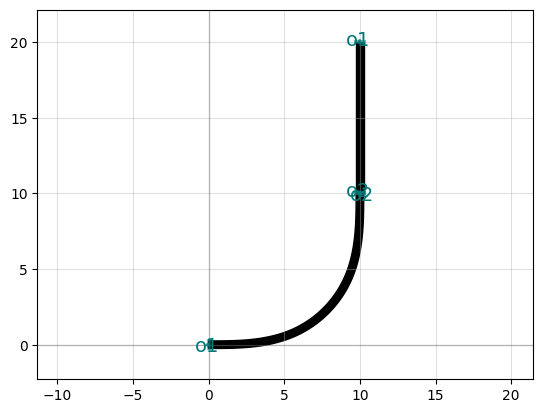

bend_with_straight: uid 76a7d00a, ports [], references ['bend_euler_1', 'straight_1'], 0 polygons

In [2]:
@gf.cell
def bend_with_straight(
    bend: ComponentSpec = gf.components.bend_euler,
    straight: ComponentSpec = gf.components.straight,
) -> gf.Component:
    c = gf.Component()
    b = gf.get_component(bend)
    s = gf.get_component(straight)

    bref = c << b
    sref = c << s

    sref.connect("o2", bref.ports["o2"])
    c.info["length"] = b.info["length"] + s.info["length"]
    return c


c = bend_with_straight()
print(c.metadata.info.length)
c

## ComponentSpec

When defining a `Parametric cell` you can use other `ComponentSpec` as an argument. It can be a:

1. string: function name of a cell registered on the active PDK. `"bend_circular"`
2. dict: `dict(component='bend_circular', settings=dict(radius=20))`
3. function: Using `functools.partial` you can customize the default parameters of a function.

### 1. string

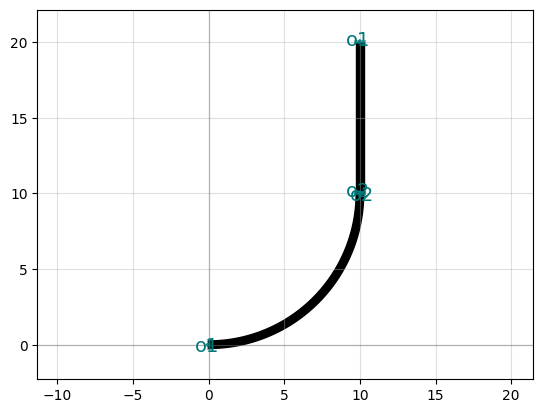

bend_with_straight_bend_840d811a: uid 5133dbf9, ports [], references ['bend_circular_1', 'straight_1'], 0 polygons

In [3]:
c = bend_with_straight(bend="bend_circular")
c

### 2. dict
Lets **customize** the functions that we pass.
For example, we want to increase the radius of the bend from the default 10um to 20um.

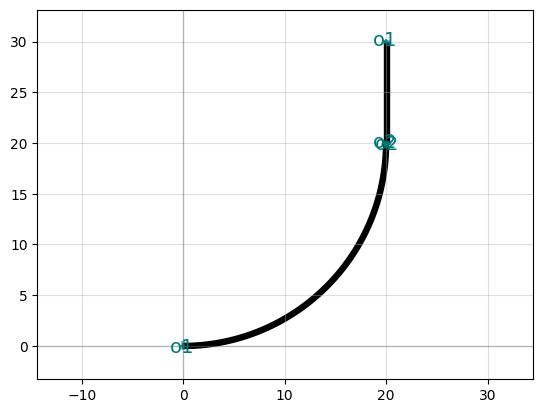

bend_with_straight_113977eb: uid ac49efe0, ports [], references ['bend_circular_1', 'straight_1'], 0 polygons

In [4]:
c = bend_with_straight(bend=dict(component="bend_circular", settings=dict(radius=20)))
c

### 3. function

Partial lets you define different default parameters for a function, so you can modify the settings for the child cells.

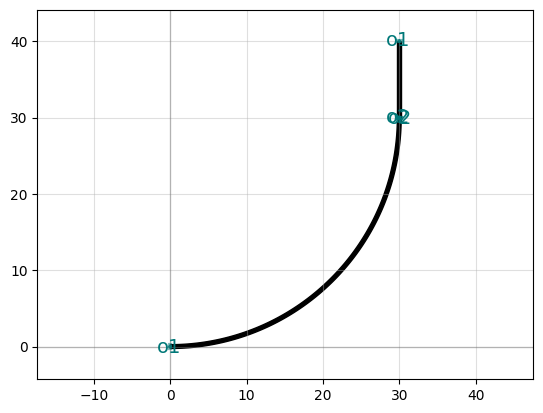

bend_with_straight_e172a9e6: uid c973b496, ports [], references ['bend_circular_1', 'straight_1'], 0 polygons

In [5]:
c = bend_with_straight(bend=gf.partial(gf.components.bend_circular, radius=30))
c

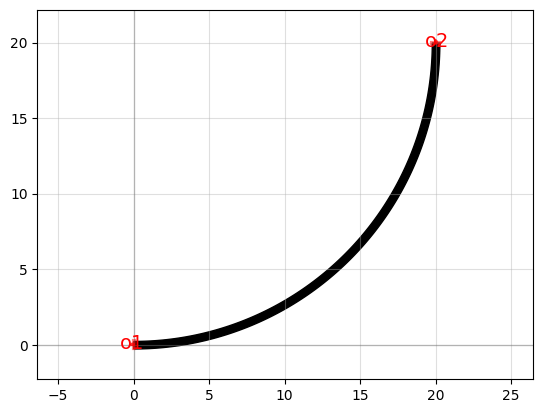

bend_circular_radius20: uid c02222c6, ports ['o1', 'o2'], references [], 1 polygons

In [6]:
from functools import partial

bend20 = partial(gf.components.bend_circular, radius=20)
b = bend20()
b

In [7]:
type(bend20)

functools.partial

In [8]:
bend20.func.__name__

'bend_circular'

In [9]:
bend20.keywords

{'radius': 20}

41.416


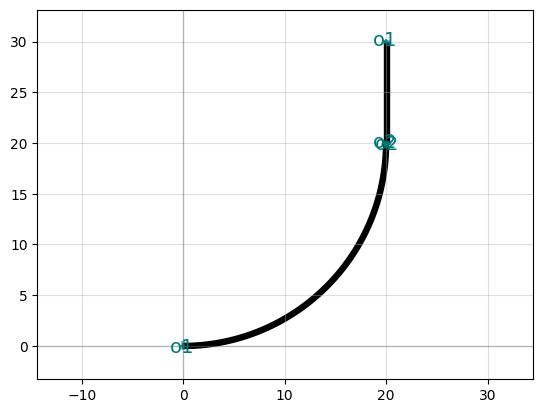

bend_with_straight_e917218d: uid 1bfcd601, ports [], references ['bend_circular_1', 'straight_1'], 0 polygons

In [10]:
b = bend_with_straight(bend=bend20)
print(b.metadata.info.length)
b

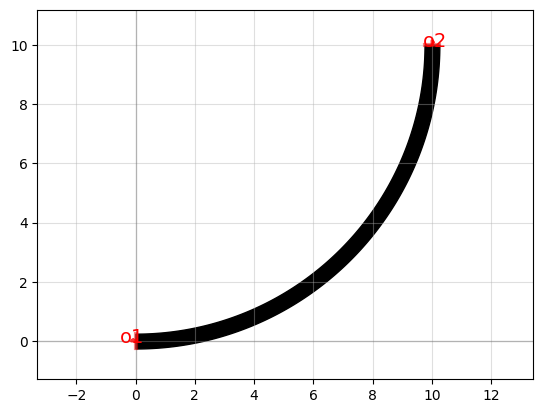

bend_circular_radius10: uid 838dfa90, ports ['o1', 'o2'], references [], 1 polygons

In [11]:
# You can still modify the bend to have any bend radius
b3 = bend20(radius=10)
b3

## PDK custom fab

You can define a new PDK by creating function that customize partial parameters of the generic functions.

Lets say that this PDK uses layer (41, 0) for the pads (instead of the layer used in the generic pad function).

You can also access `functools.partial` from `gf.partial`

In [12]:
import gdsfactory as gf

pad = gf.partial(gf.components.pad, layer=(41, 0))

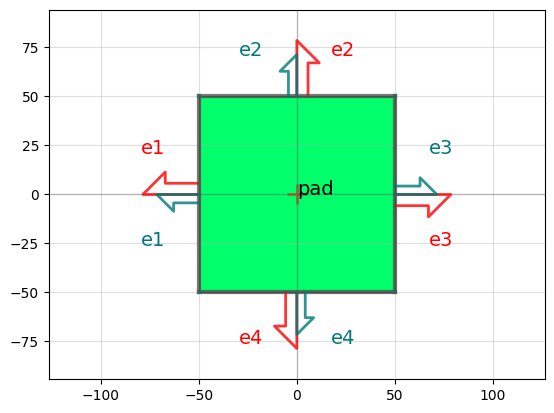

pad_layer41__0: uid 34f3a9ac, ports ['e1', 'e2', 'e3', 'e4', 'pad'], references ['compass_1'], 0 polygons

In [13]:
c = pad()
c

## Composing functions

You can combine more complex functions out of smaller functions.

Lets say that we want to add tapers and grating couplers to a wide waveguide.

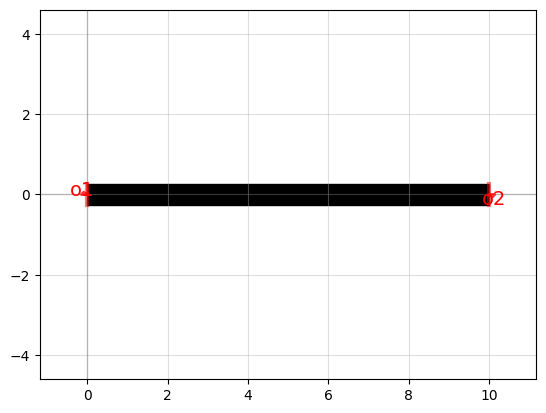

straight: uid f5fd2fbc, ports ['o1', 'o2'], references [], 1 polygons

In [14]:
c1 = gf.components.straight()
c1

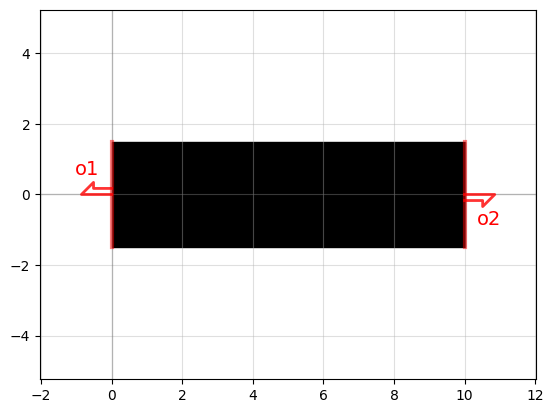

straight_width3: uid 89f47158, ports ['o1', 'o2'], references [], 1 polygons

In [15]:
straight_wide = gf.partial(gf.components.straight, width=3)
c3 = straight_wide()
c3

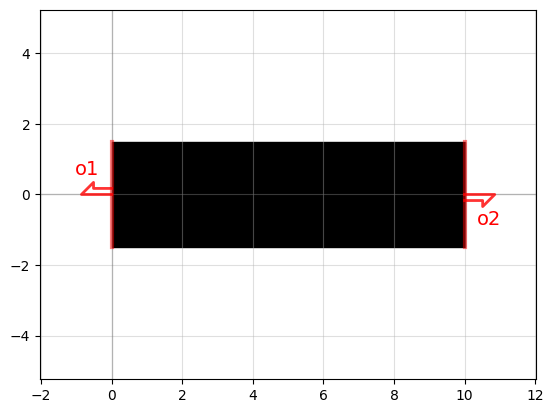

straight_width3: uid 89f47158, ports ['o1', 'o2'], references [], 1 polygons

In [16]:
c1 = gf.components.straight(width=3)
c1

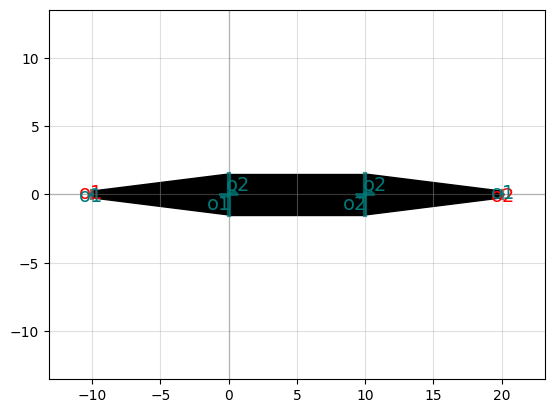

straight_width3_add_tap_9ae57f22: uid 74a4ff0c, ports ['o1', 'o2'], references ['taper_1', 'taper_2', 'straight_1'], 0 polygons

In [17]:
c2 = gf.add_tapers(c1)
c2

In [18]:
c2.metadata_child.changed  # You can still access the child metadata

{'width': 3}

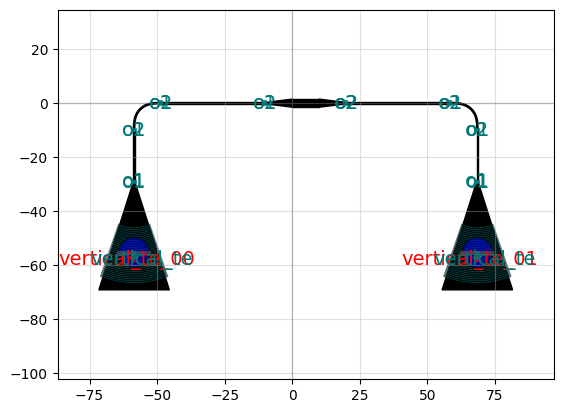

straight_width3_add_tap_c79a46d8: uid 985d7618, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'add_tapers_1'], 0 polygons

In [19]:
c3 = gf.routing.add_fiber_array(c2, with_loopback=False)
c3

In [20]:
c3.metadata_child.changed  # You can still access the child metadata

{'width': 3}

Lets do it with a **single** step thanks to `toolz.pipe`

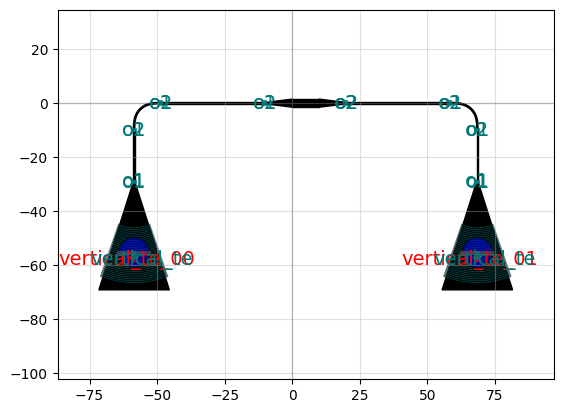

straight_width3_add_tap_c79a46d8: uid 985d7618, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'add_tapers_1'], 0 polygons

In [21]:
import toolz

add_fiber_array = gf.partial(gf.routing.add_fiber_array, with_loopback=False)
add_tapers = gf.add_tapers

# pipe is more readable than the equivalent add_fiber_array(add_tapers(c1))
c3 = toolz.pipe(c1, add_tapers, add_fiber_array)
c3

we can even combine `add_tapers` and `add_fiber_array` thanks to `toolz.compose` or `toolz.compose`

For example:

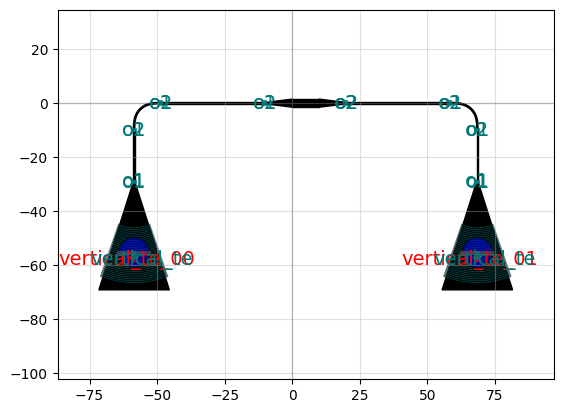

straight_width3_add_tap_c79a46d8: uid 985d7618, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'add_tapers_1'], 0 polygons

In [22]:
add_tapers_fiber_array = toolz.compose_left(add_tapers, add_fiber_array)
c4 = add_tapers_fiber_array(c1)
c4

is equivalent to

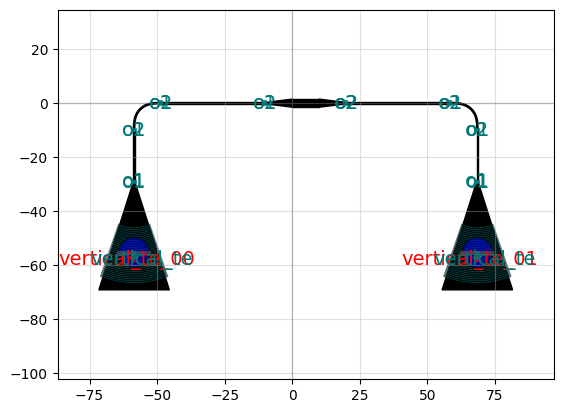

straight_width3_add_tap_c79a46d8: uid 985d7618, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'add_tapers_1'], 0 polygons

In [23]:
c5 = add_fiber_array(add_tapers(c1))
c5

as well as equivalent to

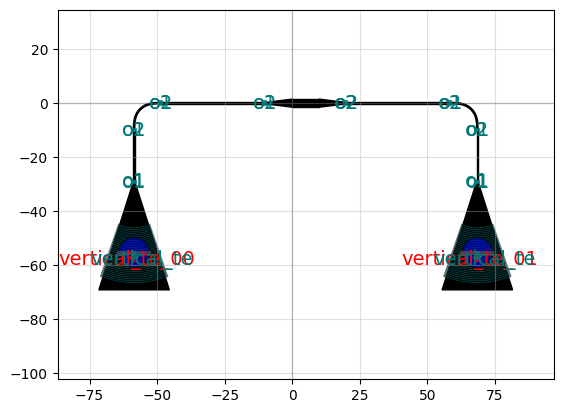

straight_width3_add_tap_c79a46d8: uid 985d7618, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'add_tapers_1'], 0 polygons

In [24]:
add_tapers_fiber_array = toolz.compose(add_fiber_array, add_tapers)
c6 = add_tapers_fiber_array(c1)
c6

or

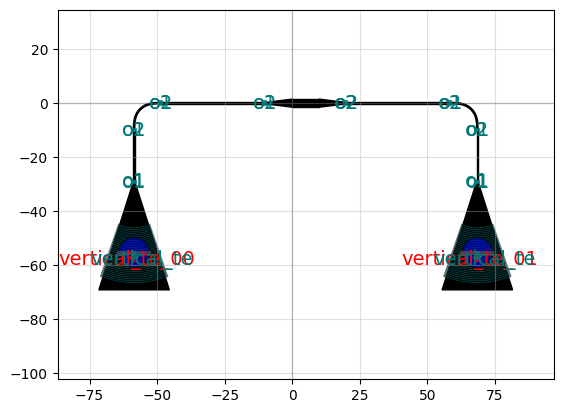

straight_width3_add_tap_c79a46d8: uid 985d7618, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'add_tapers_1'], 0 polygons

In [25]:
c7 = toolz.pipe(c1, add_tapers, add_fiber_array)
c7

In [26]:
c7.metadata_child.changed  # You can still access the child metadata

{'width': 3}

In [27]:
c7.metadata.child.child.name, c7.metadata.child.child.function_name

('straight_width3', 'straight')

In [28]:
c7.metadata.child.name, c7.metadata.child.function_name

('straight_width3_add_tap_9ae57f22', 'add_tapers')

In [29]:
c7.metadata.name, c7.metadata.function_name

('straight_width3_add_tap_c79a46d8', 'add_fiber_array')

In [30]:
c7.metadata.changed.keys()

dict_keys(['component', 'with_loopback'])